In [1]:
from functions import *
from functions_new import *

import numpy as np
import pandas as pd
import os 

import matplotlib.pylab as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle

import seaborn as sns
from seaborn import heatmap
from seaborn import kdeplot

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.signal import savgol_filter

import SOAPify
from SOAPify import SOAPclassification, calculateTransitionMatrix, normalizeMatrixByRow, getSOAPSettings
import SOAPify.HDF5er as HDF5er

from MDAnalysis import Universe as mdaUniverse
from MDAnalysis import transformations
from MDAnalysis.tests.datafiles import TPR, XTC
import MDAnalysis.analysis.msd as msd
from SOAPify.HDF5er import MDA2HDF5
from os import path
import hdbscan
from MDAnalysis.analysis import rdf

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

/home/cristina/programs/SOAPify/latest_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
XYZ_DIR = 'INPUT_files/211_600/'
XYZ_OUTDIR = '211_600/'
NAME = '211_600_every12ps' # NAME.hdf5
GROUP = "/Trajectories/"+NAME
MASK = True #be sure that mask used to create .hdf5 is the same used here

LOAD_HDF5 = True
LOAD_HDF5SOAP = True
LOAD_SOAP = True
LOAD_TimeSOAP = True
LOAD_LENS = True
dt = 1

TRJ_filename = NAME + ".xyz"  # or .lammpsdump 
TOP_filename = topo = NAME + ".data"  # or .data

XYZ_ORIG = [0, 0, 0]
COFF=6  #be sure that is the same coff used to create soaps and lenses
window_length=10
polyorder = 2
wantedTrajectory = slice(0, None, None)
wantedUniverseAtoms = "type Cu"
INIT=0
END=500
STRIDE=1

eq=0

SOAPnmax = 8
SOAPlmax = 8
SOAPatomMask = "Cu"

## Create HDF5 File from TOP and TRJ files

In [3]:
if LOAD_HDF5:
    
    if MASK:
        HDF5_TRJ  = NAME + "mask.hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
    else:
        HDF5_TRJ  = NAME + ".hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
    
else:
    mycwd = os.getcwd()
    os.chdir(XYZ_DIR)
    createHDF5(TRJ_filename, TOP_filename, wantedUniverseAtoms)  # Create HDF5 File (if not present)
    os.chdir(mycwd)
    
    if MASK:  # TODO: change HDF5 filename in mask.hdf5
        HDF5_TRJ  = NAME + "mask.hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
            
    else:
        HDF5_TRJ  = NAME + ".hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)

In [4]:
nAtoms = len(universe.atoms)
windowToUSE = slice(eq+window_length // 2, -(window_length // 2))  # checked for both EVEN and ODD windows
windowToUSE_last = slice(eq+window_length // 2, -(window_length // 2+1))

In [5]:
print(windowToUSE)
print(windowToUSE_last)

slice(5, -5, None)
slice(5, -6, None)


## Create HDF5SOAP File

In [6]:
if LOAD_SOAP:
    pass

else:
    
    mycwd = os.getcwd()
    os.chdir(XYZ_DIR)
    prepareSOAP(HDF5_TRJ_nomask, NAME, COFF, SOAPnmax, SOAPlmax, SOAPatomMask)
    os.chdir(mycwd)

# 1. TimeSOAP

## Read TimeSOAP input

In [7]:
if LOAD_TimeSOAP:
    tsoap = np.load(XYZ_DIR+'time_dSOAP.npz')['name1']
    print(np.shape(tsoap))
else:

    if MASK:
        with h5py.File(XYZ_DIR+NAME+'.hdf5', 'r') as f:
            mask = f[GROUP+"Trajectory"][0, :, 2] > 12
        
        with h5py.File(XYZ_DIR+NAME+'soap.hdf5', 'r') as f:
            ds = f["SOAP/"+NAME]
            fillSettings = getSOAPSettings(ds)
            X = ds[:][:, mask]
        
    else: 
        with h5py.File(XYZ_DIR+NAME+'soap.hdf5', 'r') as f:
            ds = f["SOAP/"+NAME]
            fillSettings = getSOAPSettings(ds)
            X = ds[:, :, :]

    X = SOAPify.fillSOAPVectorFromdscribe(
            X[:], **fillSettings)
        

    X = SOAPify.normalizeArray(X)
    np.savez(XYZ_DIR+'X_normalized.npz', name1=X)
    
    v_soap = np.load(XYZ_DIR+'X_normalized.npz')['name1'][windowToUSE]
    print(np.shape(v_soap))
    
    nAtoms, tSOAP, dtSOAP = getTimeSOAP(XYZ_DIR+NAME+'soap.hdf5', NAME)   

(2000, 995)


In [8]:
nAtoms = np.shape(tsoap)[1]

In [9]:
tsoap_fl = np.array(tsoap).reshape(np.shape(tsoap)[0]*np.shape(tsoap)[1])
np.shape(tsoap_fl)

(1990000,)

## Filtering

In [10]:
tSOAP_rolling = moving_average(np.array(tsoap).T, window_length)
min = np.min(tSOAP_rolling)
print(min)
max = np.max(tSOAP_rolling)
print(max)
tSOAP_rolling_norm = (tSOAP_rolling-min)/(max-min)  # NORMALIZATION
tr_tSOAP_rolling = np.array(tSOAP_rolling_norm).T
fl_tSOAP_rolling = np.reshape(tr_tSOAP_rolling, np.shape(tr_tSOAP_rolling)[0]*np.shape(tr_tSOAP_rolling)[1])

0.005100819307364214
0.08480519999524845


In [11]:
dataToFit = transposeAndFlatten(tSOAP_rolling_norm)
print("minmax: ", np.min(dataToFit), np.max(dataToFit))

minmax:  0.0 1.0


In [12]:
savGolPrint = np.arange(tSOAP_rolling_norm.shape[1])

In [13]:
time = np.arange(savGolPrint[0]+window_length // 2 + 1, savGolPrint[-1]+window_length // 2 + 2 )
xticks = np.array(list(filter(lambda x: (x % 500 == 0), time)))

In [14]:
xticks = [0, 500, 1000, 1500, 2000]

# 2. LENS

# Read LENS input 

In [15]:
if LOAD_LENS:
    LENS = np.load(XYZ_DIR+'lens.npy')
else:
    neigCounts = SOAPify.analysis.listNeighboursAlongTrajectory(universe, cutOff=COFF)
    LENS, nn, *_ = SOAPify.analysis.neighbourChangeInTime(neigCounts)
    np.save(XYZ_DIR+"lens", LENS)

In [16]:
LENS.shape

(995, 2001)

In [17]:
# Remove the first frame (=0.0)
LENS = LENS[:, dt:]

In [18]:
len(LENS[0])

2000

In [19]:
atom = nAtoms - 1

# Filtering

In [20]:
LENS_rolling = moving_average(LENS, window_length)
min = np.min(LENS_rolling)
print(min)
max = np.max(LENS_rolling)
print(max)
LENS_rolling_norm = (LENS_rolling-min)/(max-min)  # NORMALIZATION
tr_LENS_rolling = np.array(LENS_rolling_norm).T
fl_LENS_rolling = np.reshape(tr_LENS_rolling, np.shape(tr_LENS_rolling)[0]*np.shape(tr_LENS_rolling)[1])

0.0
0.3581555636316158


In [21]:
savGolPrint = np.arange(LENS_rolling_norm.shape[1])

In [22]:
LENS_rolling.shape

(995, 1991)

In [23]:
dataToFit = transposeAndFlatten(LENS_rolling_norm)
print("minmax: ", np.min(dataToFit), np.max(dataToFit))

minmax:  0.0 1.0


# 3. (LENS-TimeSOAP) LEAP descriptor

## 3.1 Stack descriptors and reshape

In [24]:
djoint_d = np.dstack((np.transpose(tSOAP_rolling_norm),np.transpose(LENS_rolling_norm)))

In [25]:
np.shape(djoint_d)

(1991, 995, 2)

In [26]:
djoint_d_fl = np.array(djoint_d).reshape(np.shape(djoint_d)[0]*np.shape(djoint_d)[1],np.shape(djoint_d)[2])

In [27]:
djoint_d_fl.shape

(1981045, 2)

In [28]:
LEAP = []

for i in range(0, len(djoint_d_fl)):
    leap = np.sqrt(djoint_d_fl[i, 1]**2+djoint_d_fl[i, 0]**2)
    
    LEAP.append(leap)

In [29]:
ts_LEAP = np.array(LEAP).reshape(LENS_rolling_norm.shape[1], LENS_rolling_norm.shape[0])
ts_LEAP = ts_LEAP.transpose()

## 3.3 2D Onion Clustering

In [30]:
signal_x = []
signal_y = []
clusters_j = []

with open(XYZ_DIR+'signal_with_labels.dat', 'r') as f:
    lines = f.readlines()
    
    for idx, line in enumerate(lines[1:]):
        row = line.split()
        signal_x.append(float(row[0]))
        signal_y.append(float(row[1]))
        clusters_j.append(int(row[2]))

In [31]:
x_dim = len(signal_x)
y_dim = len(signal_y)

In [32]:
signal_joint_fl = np.empty((x_dim, 2))

for i in range(0, x_dim):
    signal_joint_fl[i][0] = signal_x[i]
    signal_joint_fl[i][1] = signal_y[i]    

In [33]:
signal_joint_fl.shape

(1970100, 2)

In [34]:
OnionCL_len = int(signal_joint_fl.shape[0]/djoint_d.shape[1])  #Get the length of data AFTER ONION clustering

In [35]:
OnionCL_len

1980

In [36]:
djoint_dCUT = np.dstack((np.transpose(tSOAP_rolling_norm[:, 0:OnionCL_len]),np.transpose(LENS_rolling_norm[:, 0:OnionCL_len])))

In [37]:
djoint_dCUT.shape

(1980, 995, 2)

In [68]:
djoint_dCUT_fl = np.array(djoint_dCUT).reshape(np.shape(djoint_dCUT)[0]*np.shape(djoint_dCUT)[1],np.shape(djoint_dCUT)[2])

In [38]:
diffCUT = djoint_d.shape[0] - OnionCL_len
windowToUSE_CUT = slice(eq+window_length // 2, -(window_length // 2+diffCUT))

## 3.5 Get Fluctuations from 1D Onion clusters

In [42]:
# Data from Onion_Clustering/211_600/1D-tsoap/final_states.txt
sigma_lastCL_tSOAP = 0.14
mu_lastCL_tSOAP = 0.45

# Data from Onion_Clustering/211_600/1D-lens/final_states.txt
sigma_lastCL_LENS = 0.2
mu_lastCL_LENS = 0.43

# Data from Onion_Clustering/211_600/1D-lens/final_thresholds.txt
last_thr_tSOAP = 0.5
last_thr_LENS = 0.35

In [43]:
FLUCT_thr_tSOAP = last_thr_tSOAP
FLUCT_thr_LENS = last_thr_LENS

## Get Confidence intervals to identify tSOAP and LENS fluctuations

In [45]:
data_tSOAP_high = []
for particle in range(0, np.shape(djoint_d)[1]):
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 0] > last_thr_tSOAP:
            data_tSOAP_high.append(djoint_d[i, particle, 0]) 

In [46]:
print(np.mean(data_tSOAP_high))
print(np.std(data_tSOAP_high))

0.5456452392883502
0.04503478079552991


In [47]:
data_LENS_high = []
for particle in range(0, np.shape(djoint_d)[1]):
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 1] > last_thr_LENS:
            data_LENS_high.append(djoint_d[i, particle, 1]) 

In [48]:
print(np.mean(data_LENS_high))
print(np.std(data_LENS_high))

0.4932501588365938
0.11177337004445055


In [49]:
Sup_thr_tSOAP = np.mean(data_tSOAP_high) - np.std(data_tSOAP_high)
Sup_thr_LENS = np.mean(data_LENS_high) - np.std(data_LENS_high)

In [50]:
Sup_thr_tSOAP

0.5006104584928203

In [51]:
Sup_thr_LENS

0.38147678879214325

In [52]:
Inf_thr_tSOAP = np.mean(data_tSOAP_high) - 2*np.std(data_tSOAP_high)
Inf_thr_LENS = np.mean(data_LENS_high) - 2*np.std(data_LENS_high)

In [53]:
Inf_thr_tSOAP 

0.45557567769729035

In [54]:
Inf_thr_LENS

0.26970341874769266

## Chi parameter

In [55]:
slope = np.empty((djoint_d.shape[1], djoint_d.shape[0]))
for frame in range(0, djoint_d.shape[0]):
    for particle in range(0, djoint_d.shape[1]):
        slope[particle][frame] = float((djoint_d[frame][particle][1]-djoint_d[frame][particle][0]) / (djoint_d[frame][particle][0]+djoint_d[frame][particle][1]))

In [56]:
lag_time = []
particle_founded = []
init_frame_for_particle = []
for particle in range(0, slope.shape[0]):
    found_blue = 0
    found_red = 0
    count_red = 0
    found_lag = 0
    frame_blue = []
    frame_red = []
    for frame in range(0, slope.shape[1]):
        if djoint_d[frame][particle][0] > Sup_thr_tSOAP and djoint_d[frame][particle][1] < Inf_thr_LENS and count_red==0:
            found_blue = 1
            frame_blue.append(frame)

            
        if djoint_d[frame][particle][1] > Sup_thr_LENS and djoint_d[frame][particle][0] < Inf_thr_tSOAP and found_blue == 1:
            frame_red.append(frame)
                
            count_red = count_red + 1
        if djoint_d[frame][particle][0] < Sup_thr_LENS:
            count_red = 0
            frame_red = []
            
        if count_red > 5 and found_lag == 0:
            lag_time.append(np.min(frame_red)-np.max(frame_blue))
            particle_founded.append(particle)
            init_frame_for_particle.append(np.max(frame_blue))
            found_lag = 1
                

In [57]:
particle_founded

[59, 130, 239, 420, 460, 639, 658, 807, 826, 926, 975]

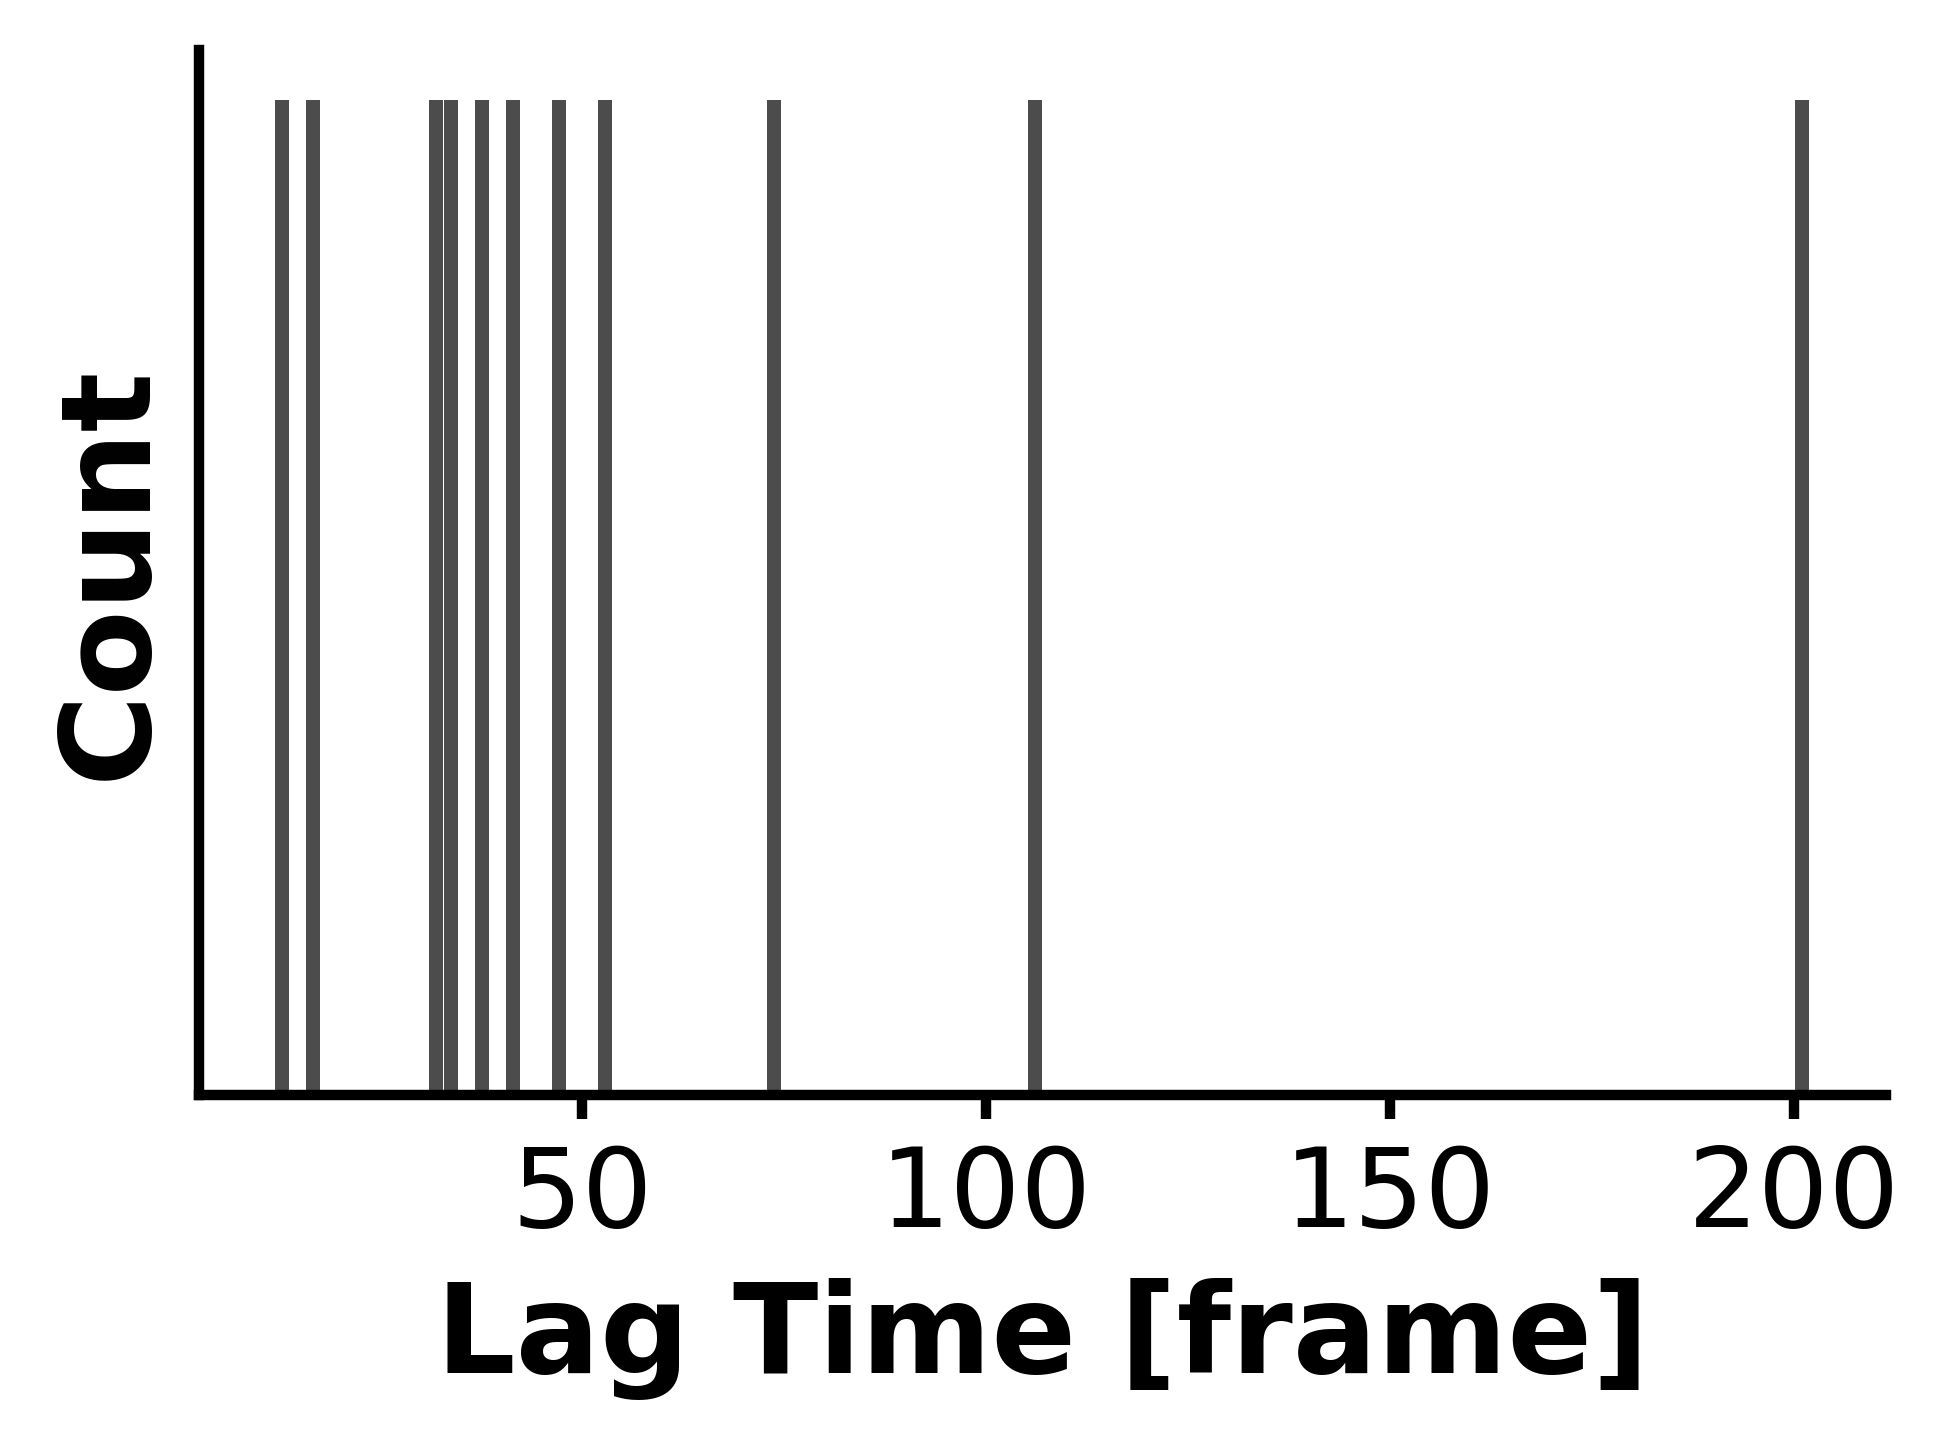

In [58]:
fig, ax = plt.subplots(1, figsize=(4,3), dpi=500, tight_layout=True)
# sns.kdeplot(data=distance, color='black', bw_adjust=0.4, linewidth=2, fill=False)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 4)
ax.set_xlabel('Lag Time [frame]', weight='bold', size=18)
# ax.set_xticks([0, 10, 20, 30, 40, 50])
# ax.set_xticklabels([0, 10, 20, 30, 40, 50], size=12)
ax.set_ylabel('Count', weight='bold', size=18)
ax.set_yticks([])

plt.hist(x=lag_time, bins=100, color='black',
                            alpha=0.7, rwidth=0.9)

# ax.set_xlim(0, 50)
for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,
    left=True,      
    labelleft=True,
    labelbottom=True,
    width=1.5,
    labelsize=16,
) 
plt.savefig(XYZ_OUTDIR+'Figure/lagtime.png')

In [59]:
from statistics import mode
most_frequent = mode(lag_time)
most_frequent

53

In [60]:
lag_time

[53, 17, 48, 33, 37, 31, 74, 12, 106, 202, 42]

In [61]:
rephased_slope = []
for p in range(0, len(particle_founded)):
    particle = particle_founded[p]
    init_frame = init_frame_for_particle[p]
    rephased_slope.append(slope[particle][init_frame:])

In [62]:
time = np.arange(0, 1991)

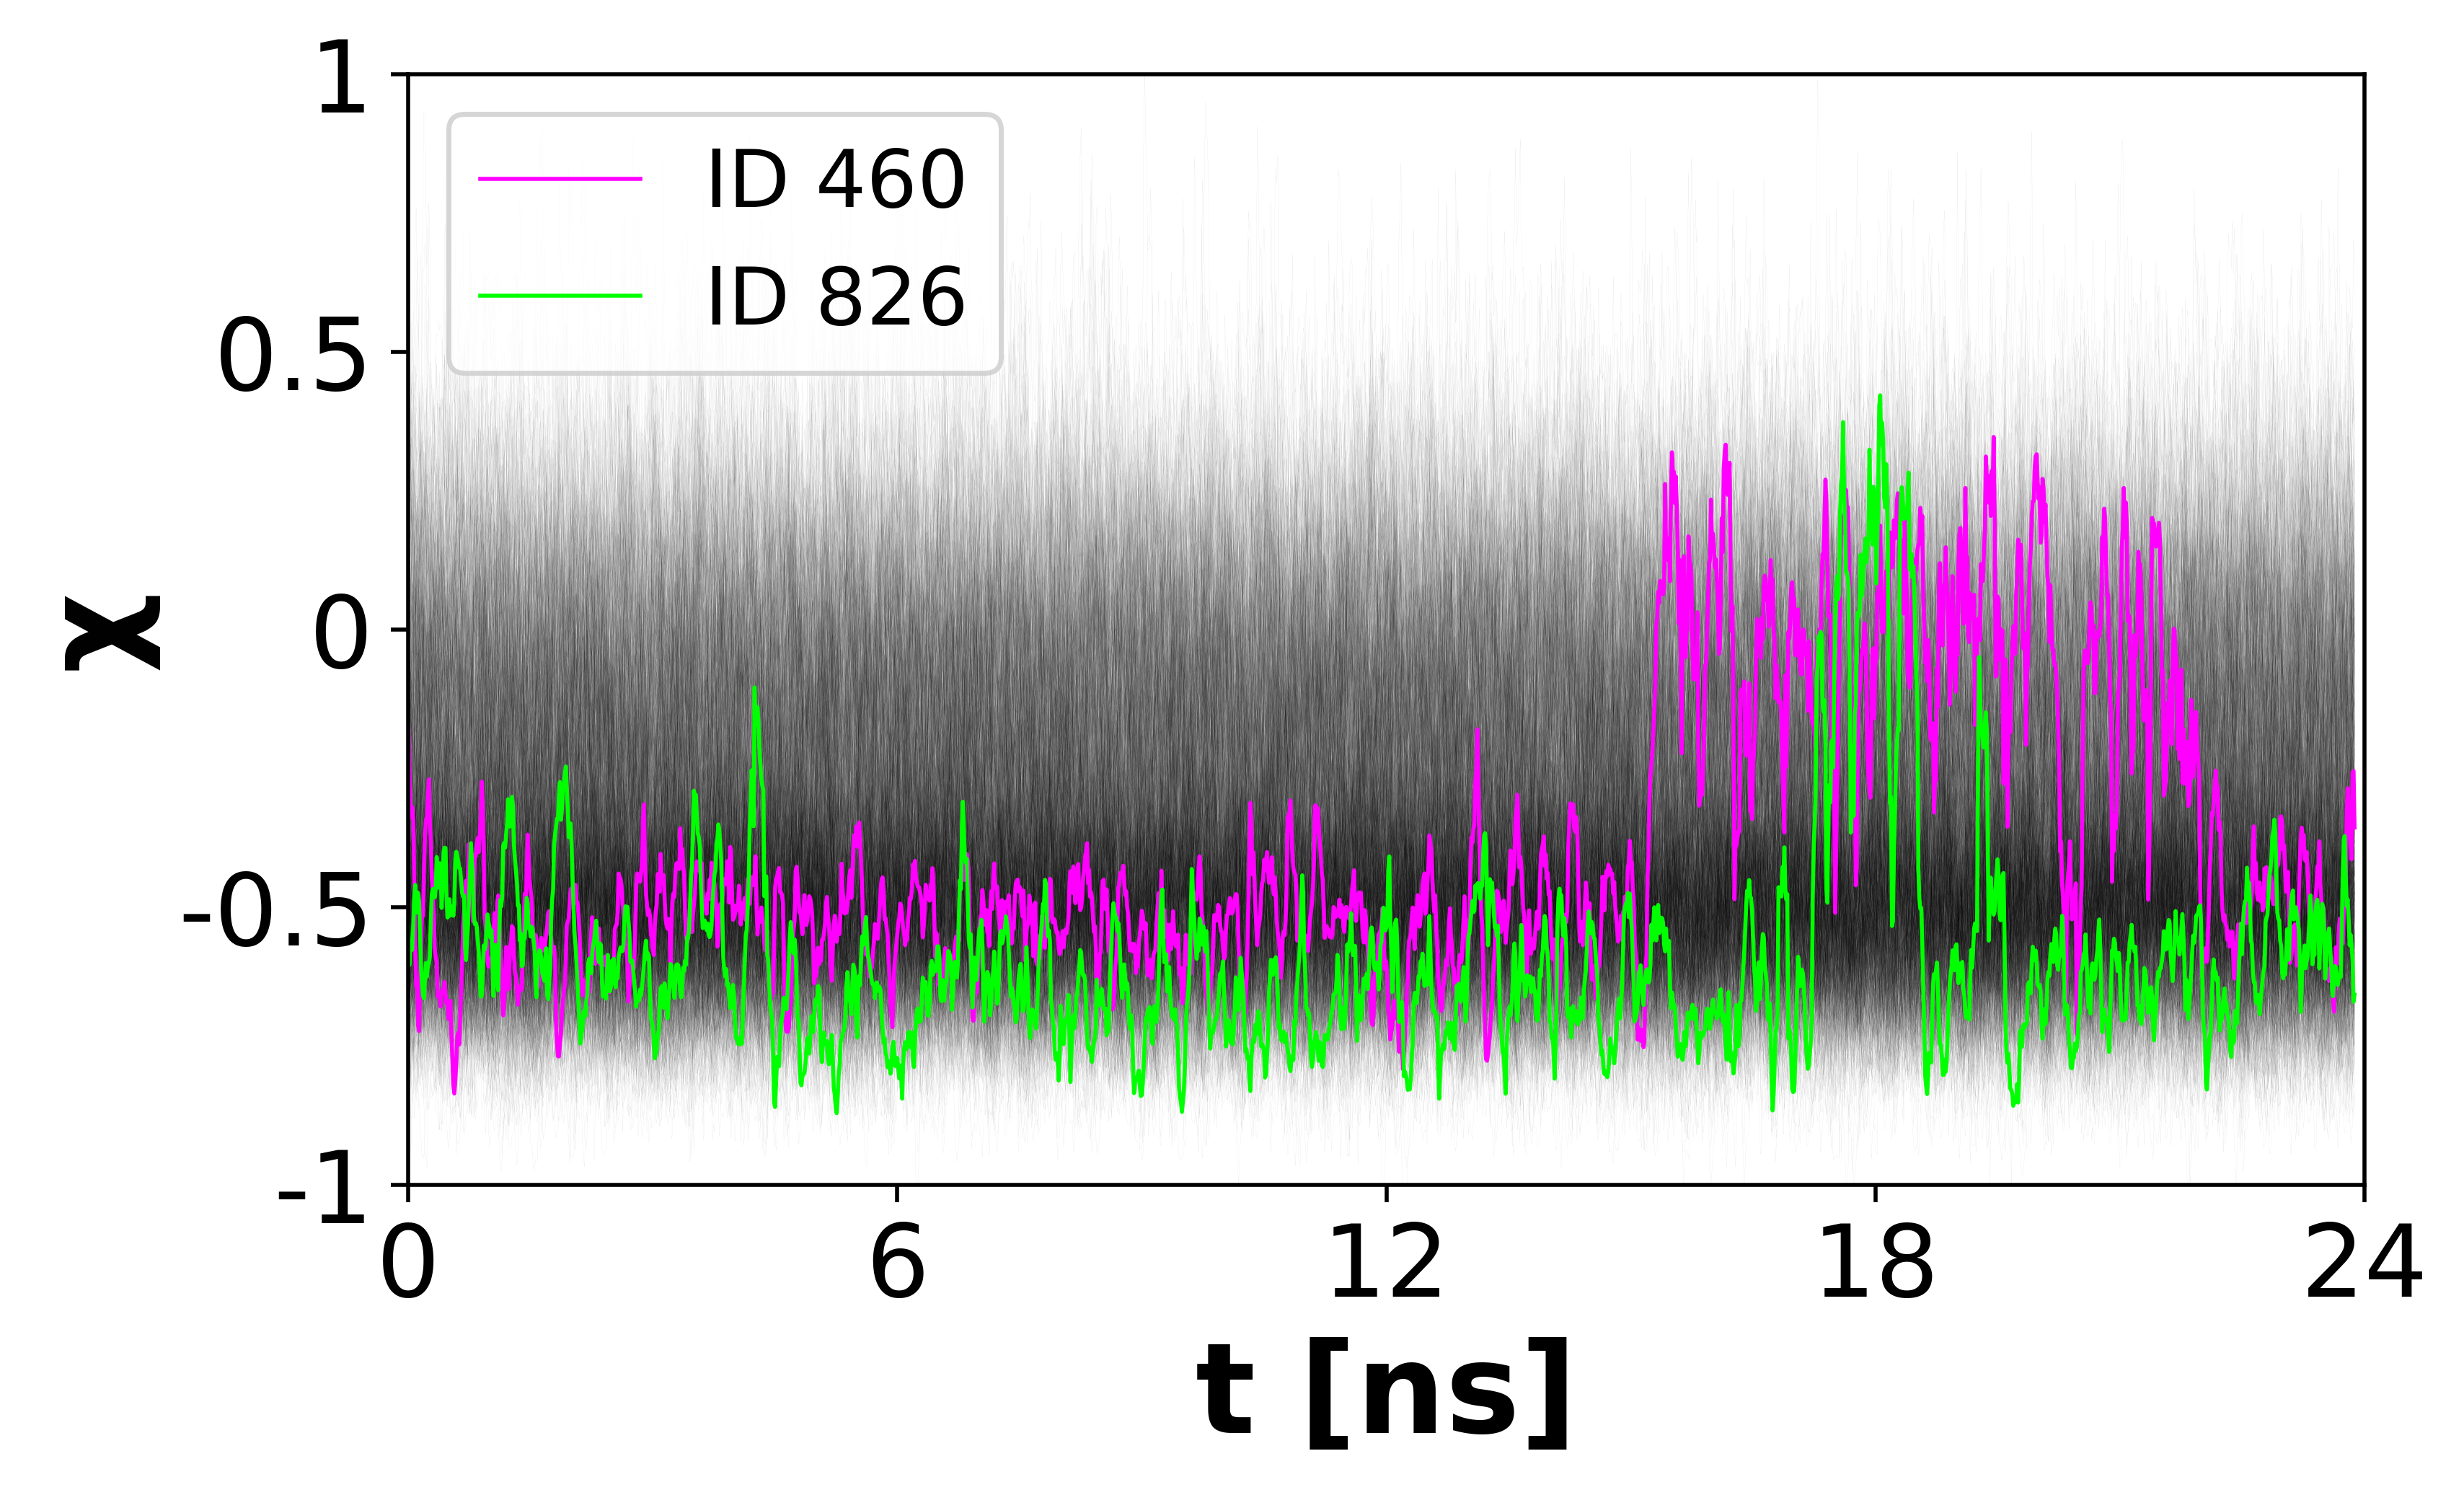

In [63]:
fig, axes = plt.subplots(
    1, figsize=(7, 4), dpi=500
)



for i in range(0, len(slope)):
    
    axes.plot(
        time,
        slope[i],
        color="black",
        linewidth=0.02,
        alpha=0.2,
    )
    
axes.plot(
        time,
        slope[460],
        color="magenta",
        linewidth=0.8,
        alpha=1,
        label=r'ID 460'
    )

axes.plot(
        time,
        slope[826],
        color="lime",
        linewidth=0.8,
        alpha=1,
        label=r'ID 826'
    )
    
    


axes.set_xlim(0, 2000)
axes.set_xlabel(r't [ns]', weight = 'bold', size=25)
axes.set_xticks([0, 500, 1000, 1500, 2000])
axes.set_xticklabels([0, 6, 12, 18, 24], fontsize=20)

axes.set_ylabel(r'χ', weight = 'bold', size=25)
axes.set_yticks([-1, -0.5, 0, 0.5, 1])
axes.set_yticklabels([-1, -0.5, 0, 0.5, 1], fontsize=20)
axes.set_ylim(-1, 1)
plt.legend(fontsize=16, loc='upper left')


plt.subplots_adjust(wspace=0.08)
plt.savefig(XYZ_OUTDIR+'Figure/CHIparameter.png', bbox_inches='tight')

## 3.7 Spatial Correlation Analysis

In [69]:
clusters_FLUCT = []
cluster_tmp = 0

for i in range(0, len(djoint_dCUT_fl)):
    found = 0
    if djoint_dCUT_fl[i, 0] > Sup_thr_tSOAP and djoint_dCUT_fl[i, 1] < Inf_thr_LENS:
        cluster_tmp = 1
        clusters_FLUCT.append(cluster_tmp)
        found = 1
    if djoint_dCUT_fl[i, 1] > Sup_thr_LENS and djoint_dCUT_fl[i, 0] < Inf_thr_tSOAP:
        cluster_tmp = 2
        clusters_FLUCT.append(cluster_tmp)
        found = 1
    if found == 0:
        cluster_tmp = 0
        clusters_FLUCT.append(cluster_tmp)

In [70]:
clusters_FLUCT = np.array(clusters_FLUCT)

In [71]:
reshaped_labels_FLUCT = prepareData(clusters_FLUCT.reshape(np.shape(djoint_dCUT)[0],np.shape(djoint_dCUT)[1]))
export(XYZ_OUTDIR+NAME+'Clusters_FLUCT.xyz',  XYZ_DIR+HDF5_TRJ, windowToUSE_CUT, GROUP, XYZ_ORIG, reshaped_labels_FLUCT, SOAPatomMask)

In [72]:
with open(XYZ_OUTDIR+NAME+'Clusters_FLUCT.xyz', 'r') as f:
    lines = f.readlines()
    
    distance = []
    for line_num, line in enumerate(lines):
        if line.startswith('995') or line.startswith('Properties'):
            
            count = 0
            position1 = []
            position2 = []
            found = False
            
        else:
            count = count + 1
            found = True
            
        if found==True:
            
            row = line.split()
            
            if row[4] == '1':
            
                x1 = float(row[1])
                y1 = float(row[2])
                z1 = float(row[3])
                
                position1.append(np.array([x1, y1, z1]))
            
            if row[4] == '2':
                
                x2 = float(row[1])
                y2 = float(row[2])
                z2 = float(row[3])
                
                position2.append(np.array([x2, y2, z2]))
            
            if count == 995:
            
                for i in range(0, len(position1)):
                    for j in range(0, len(position2)):
                    
                        distance.append(np.linalg.norm(position1[i] - position2[j]))        

In [73]:
np.min(distance)

2.150697212694883

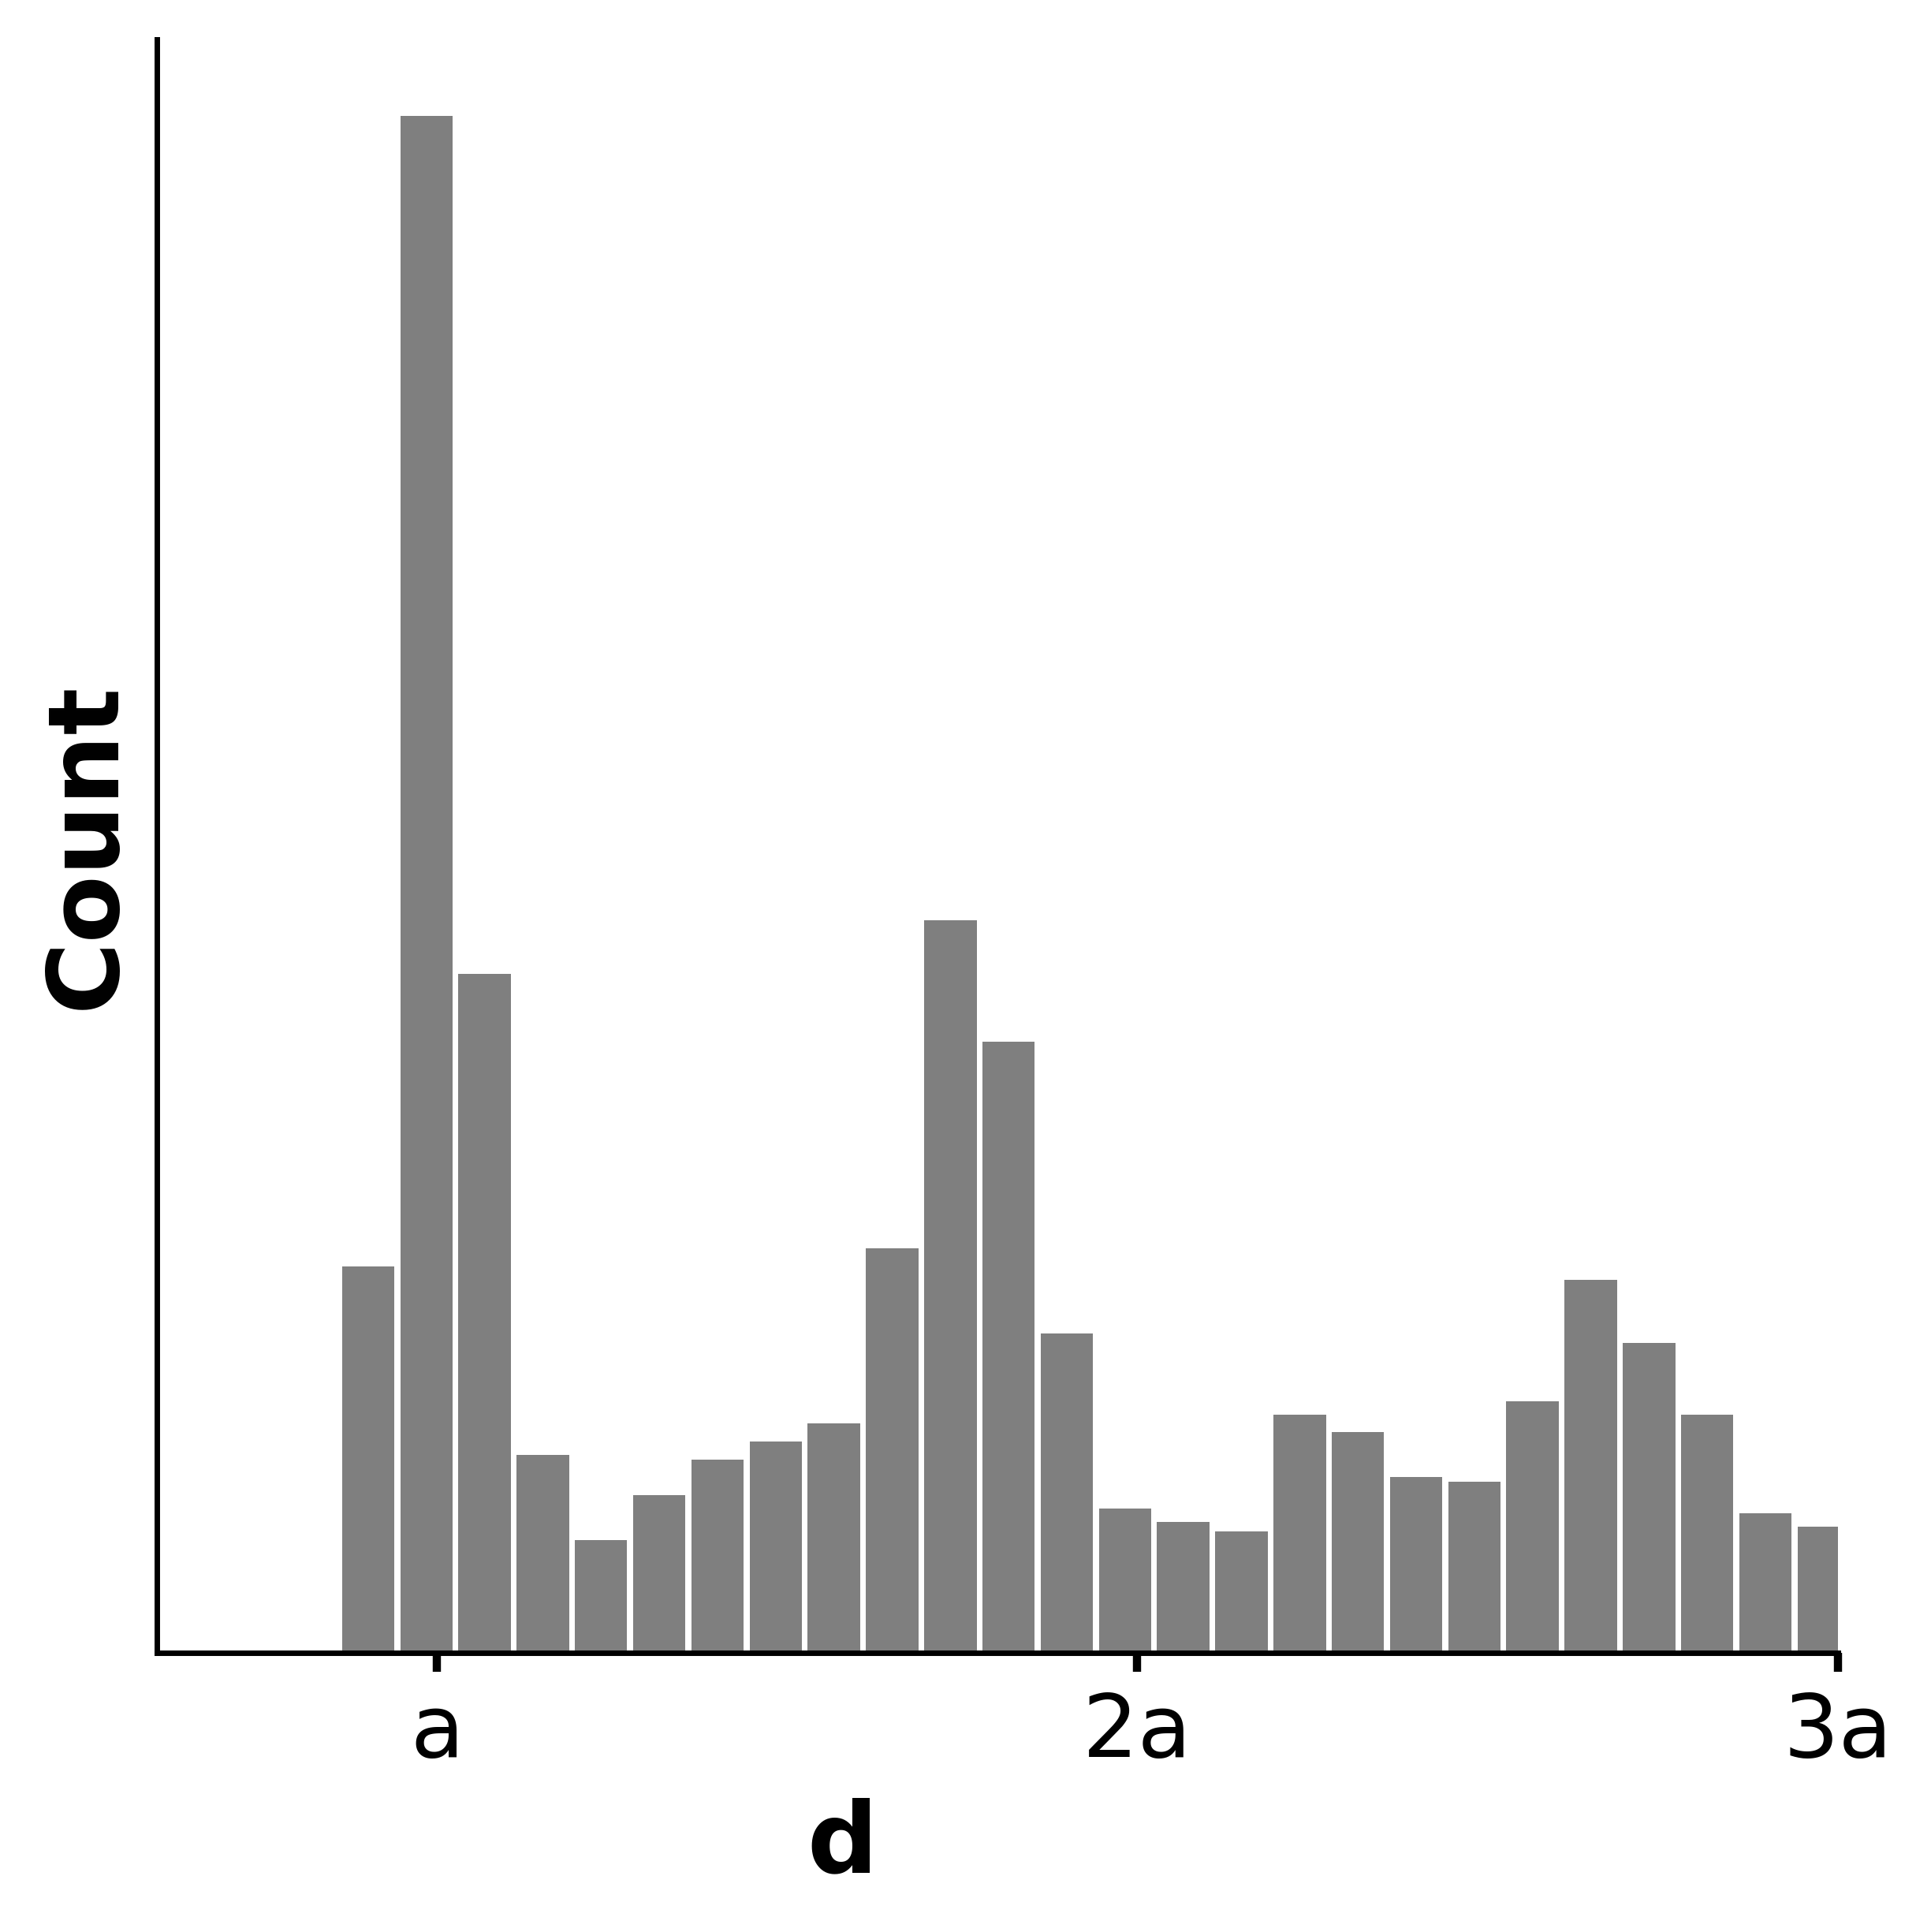

In [74]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=500, tight_layout=True)
# sns.kdeplot(data=distance, color='black', bw_adjust=0.4, linewidth=2, fill=False)

ax.set_xlim(0, 7.5)
# ax.set_ylim(0, 4)
ax.set_xlabel('d         ', weight='bold', size=18)
xticks = [0, 2.5, 5, 7.5]
ax.set_xticks(xticks)
ax.set_xticklabels([0, 'a', '2a', '3a'], size=12)
ax.set_ylabel('Count', weight='bold', size=18)
ax.set_yticks([])

plt.hist(x=distance, bins=300, color='black',
                            alpha=0.5, rwidth=0.9)

ax.set_xlim(1.5, 7.5)
for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.0)
    
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,
    left=True,      
    labelleft=True,
    labelbottom=True,
    width=1.5,
    labelsize=16,
) 


plt.savefig(XYZ_OUTDIR+'Figure/distance.png', bbox_inches='tight')

In [75]:
palette_FLUCT = ['white', 'blue', 'red']
palette_FLUCT = sns.color_palette(palette_FLUCT)
palette_FLUCT

[(1.0, 1.0, 1.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0)]

## Time-Spatial Correlation

In [736]:
COFF_NNJOINT = 6

In [737]:
neigList = SOAPify.analysis.listNeighboursAlongTrajectory(universe, cutOff=COFF_NNJOINT, trajSlice=windowToUSE)

In [738]:
neigList_tr = np.transpose(neigList)

/home/cristina/programs/SOAPify/latest_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [739]:
neigList_tr.shape

(995, 1991)

In [740]:
# Remove the particle ITSELF from the neighbor list
for particle in range(0, neigList_tr.shape[0]):
    for frame in range(0, neigList_tr.shape[1]):
        index = np.where(neigList_tr[particle][frame] == particle)[0][0]
        neigList_tr[particle][frame] = np.delete(neigList_tr[particle][frame], index)

## LENS particle vs. tSOAP neig (and vice-versa)

In [741]:
LEAP_val = []
LEAP_neig = []
tSOAP_neig = []
tSOAP_neig_MAX = []
tSOAP_val = []
LENS_neig = []
LENS_neig_MAX = []
LENS_val = []
pearson_neig = []

t_prev = 0
for particle in range(0, tSOAP_rolling_norm.shape[0]):
    s1 = LENS_rolling_norm[particle]
    for frame in range(0, tSOAP_rolling_norm.shape[1]):
        
        LEAP_val.append(ts_LEAP[particle][frame])
        LENS_val.append(LENS_rolling_norm[particle][frame])
        tSOAP_val.append(tSOAP_rolling_norm[particle][frame])
    
        LEAP_neig_tmp = []
        tSOAP_neig_tmp = []
        LENS_neig_tmp = []
        for other_particle in neigList_tr[particle][frame-t_prev]:
            s2 = tSOAP_rolling_norm[other_particle]
            
            LEAP_neig_tmp.append(ts_LEAP[other_particle][frame-t_prev])
            tSOAP_neig_tmp.append(tSOAP_rolling_norm[other_particle][frame-t_prev])
            LENS_neig_tmp.append(LENS_rolling_norm[other_particle][frame-t_prev])
            
        
        LEAP_neig.append(np.mean(LEAP_neig_tmp))
        tSOAP_neig.append(np.mean(tSOAP_neig_tmp))
        tSOAP_neig_MAX.append(np.max(tSOAP_neig_tmp))
        LENS_neig.append(np.mean(LENS_neig_tmp))
        LENS_neig_MAX.append(np.max(LENS_neig_tmp))

In [742]:
tSOAP_val_arr = np.array(tSOAP_val)

In [743]:
LENS_val_arr = np.array(LENS_val)

In [744]:
tSOAP_neig_arr = np.array(tSOAP_neig)

In [745]:
LENS_neig_arr = np.array(LENS_neig)

/home/cristina/Desktop/PhD/LEAP/FINAL_v/functions_new.py:83: RuntimeWarning: divide by zero encountered in log
  lh = numpy.log(h)
/tmp/ipykernel_50643/4057124400.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_50643/4057124400.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])


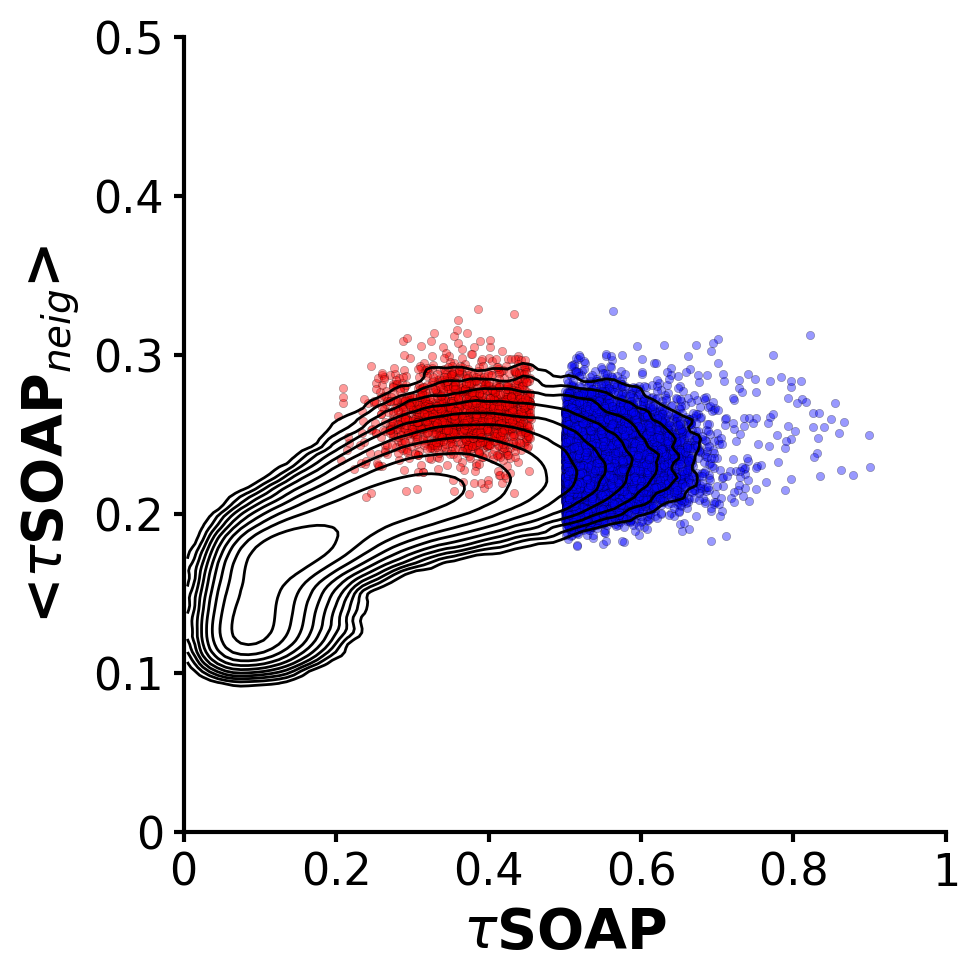

In [746]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)


# for i in range(0, len(LEAP_val)):
# ax.scatter(tSOAP_val, tSOAP_neig, marker='.', color='thistle', edgecolors='black', linewidths=0.5, alpha=0.2)
tmp = np.where(np.logical_and(tSOAP_val_arr > Sup_thr_tSOAP, LENS_val_arr < Inf_thr_LENS))
ax.scatter(tSOAP_val_arr[tmp], tSOAP_neig_arr[tmp], marker='.', color='blue', edgecolors='black', linewidths=0.2, alpha=0.4)

tmp = np.where(np.logical_and(LENS_val_arr > Sup_thr_LENS, tSOAP_val_arr < Inf_thr_tSOAP))
ax.scatter(tSOAP_val_arr[tmp], tSOAP_neig_arr[tmp], marker='.', color='red', edgecolors='black', linewidths=0.2, alpha=0.4)
        
xy = [ [0]*2 for i in range(len(tSOAP_val))]
for i in range(0, len(tSOAP_val)):
    xy[i][0] = tSOAP_val[i]
    xy[i][1] = tSOAP_neig[i]
    
xy = np.array(xy)
lh, Xe, Ye, lhmin = getDensity(xy, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=1,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)
        
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'$\tau$SOAP', weight='bold',size=20)
ax.set_ylabel(r'<$\tau$SOAP$_{neig}$>', weight='bold',size=20)


for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)  


plt.savefig(XYZ_OUTDIR+'Figure/tSOAP_tSOAPneig.png')

/tmp/ipykernel_50643/875924460.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_50643/875924460.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])


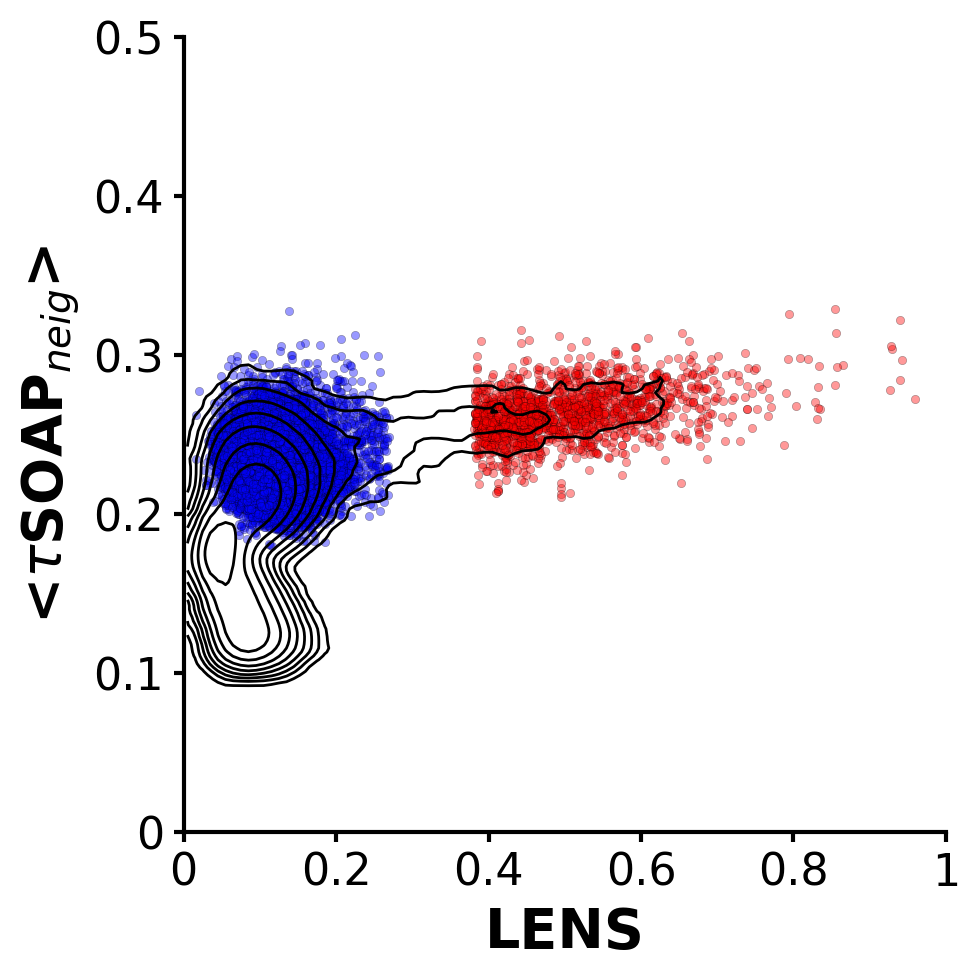

In [748]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)

# for i in range(0, len(LEAP_val)):
# ax.scatter(LENS_val, tSOAP_neig, marker='.', color='thistle', edgecolors='black', linewidths=0.5, alpha=0.2)

tmp = np.where(np.logical_and(tSOAP_val_arr > Sup_thr_tSOAP, LENS_val_arr < Inf_thr_LENS))
ax.scatter(LENS_val_arr[tmp], tSOAP_neig_arr[tmp], marker='.', color='blue', edgecolors='black', linewidths=0.2, alpha=0.4)

tmp = np.where(np.logical_and(LENS_val_arr > Sup_thr_LENS, tSOAP_val_arr < Inf_thr_tSOAP))
ax.scatter(LENS_val_arr[tmp], tSOAP_neig_arr[tmp], marker='.', color='red', edgecolors='black', linewidths=0.2, alpha=0.4)

xy = [ [0]*2 for i in range(len(LENS_val))]
for i in range(0, len(LENS_val)):
    xy[i][0] = LENS_val[i]
    xy[i][1] = tSOAP_neig[i]
    
xy = np.array(xy)
lh, Xe, Ye, lhmin = getDensity(xy, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=1.0,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)

# for i in range(0, len(LENS_val)):
#     if LENS_val[i] > 0.5:
#         ax.scatter(LENS_val[i], tSOAP_neig[i], marker='.', color='lime', edgecolors='black', linewidths=0.5, alpha=0.5)
#     if tSOAP_val[i] > 0.7:
#         ax.scatter(LEAP_val[i], tSOAP_neig[i], marker='.', color='red', edgecolors='black', linewidths=0.5, alpha=0.5)

        
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'LENS', weight='bold',size=20)
ax.set_ylabel(r'<$\tau$SOAP$_{neig}$>', weight='bold',size=20)


for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)  

plt.savefig(XYZ_OUTDIR+'Figure/LENS_tSOAPneig.png')

/tmp/ipykernel_50643/4003916157.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_50643/4003916157.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])


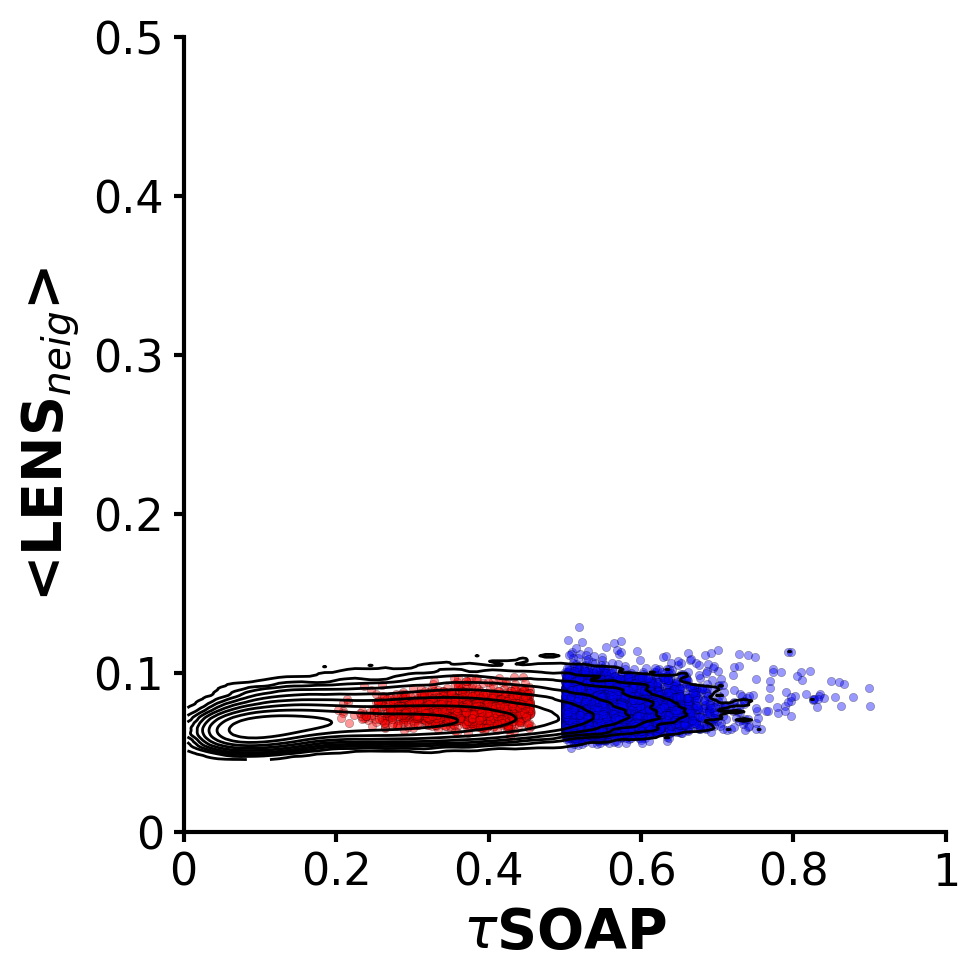

In [749]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)

# for i in range(0, len(LEAP_val)):
# ax.scatter(tSOAP_val, LENS_neig, marker='.', color='thistle', edgecolors='black', linewidths=0.5, alpha=0.2)

tmp = np.where(np.logical_and(tSOAP_val_arr > Sup_thr_tSOAP, LENS_val_arr < Inf_thr_LENS))
ax.scatter(tSOAP_val_arr[tmp], LENS_neig_arr[tmp], marker='.', color='blue', edgecolors='black', linewidths=0.2, alpha=0.4)

tmp = np.where(np.logical_and(LENS_val_arr > Sup_thr_LENS, tSOAP_val_arr < Inf_thr_tSOAP))
ax.scatter(tSOAP_val_arr[tmp], LENS_neig_arr[tmp], marker='.', color='red', edgecolors='black', linewidths=0.2, alpha=0.4)

xy = [ [0]*2 for i in range(len(tSOAP_val))]
for i in range(0, len(LENS_val)):
    xy[i][0] = tSOAP_val[i]
    xy[i][1] = LENS_neig[i]
    
xy = np.array(xy)
lh, Xe, Ye, lhmin = getDensity(xy, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=1.0,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)
# for i in range(0, len(LENS_val)):
#     if LENS_val[i] > 0.5:
#         ax.scatter(LENS_val[i], tSOAP_neig[i], marker='.', color='lime', edgecolors='black', linewidths=0.5, alpha=0.5)
#     if tSOAP_val[i] > 0.7:
#         ax.scatter(LEAP_val[i], tSOAP_neig[i], marker='.', color='red', edgecolors='black', linewidths=0.5, alpha=0.5)

        
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'$\tau$SOAP', weight='bold',size=20)
ax.set_ylabel(r'<LENS$_{neig}$>', weight='bold',size=20)


for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)  

plt.savefig(XYZ_OUTDIR+'Figure/tSOAP_LENSneig.png')

/tmp/ipykernel_50643/854950357.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_50643/854950357.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])


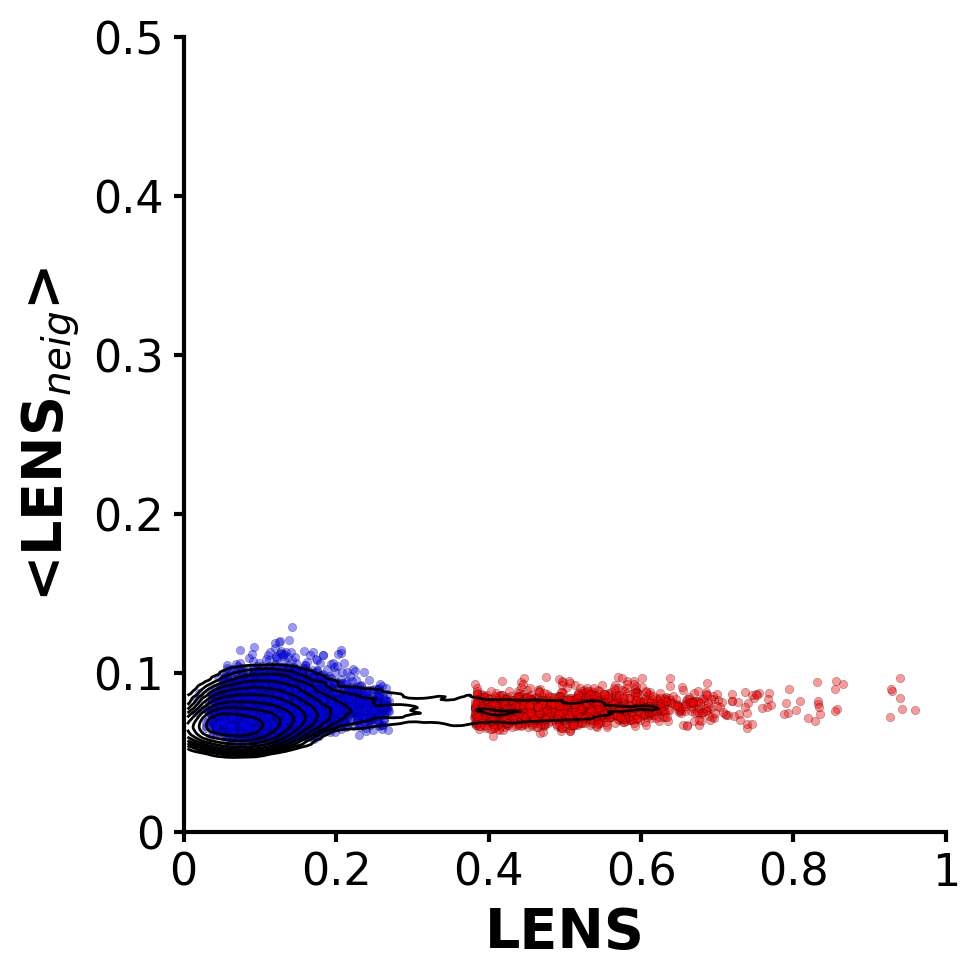

In [750]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)

# for i in range(0, len(LEAP_val)):
# ax.scatter(LENS_val, LENS_neig, marker='.', color='thistle', edgecolors='black', linewidths=0.5, alpha=0.2)

tmp = np.where(np.logical_and(tSOAP_val_arr > Sup_thr_tSOAP, LENS_val_arr < Inf_thr_LENS))
ax.scatter(LENS_val_arr[tmp], LENS_neig_arr[tmp], marker='.', color='blue', edgecolors='black', linewidths=0.2, alpha=0.4)
tmp = np.where(np.logical_and(LENS_val_arr > Sup_thr_LENS, tSOAP_val_arr < Inf_thr_tSOAP))
ax.scatter(LENS_val_arr[tmp], LENS_neig_arr[tmp], marker='.', color='red', edgecolors='black', linewidths=0.2, alpha=0.4)

xy = [ [0]*2 for i in range(len(LENS_val))]
for i in range(0, len(LENS_val)):
    xy[i][0] = LENS_val[i]
    xy[i][1] = LENS_neig[i]
    
xy = np.array(xy)
lh, Xe, Ye, lhmin = getDensity(xy, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=1.0,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)
# for i in range(0, len(LENS_val)):
#     if LENS_val[i] > 0.5:
#         ax.scatter(LEAP_val[i], tSOAP_neig[i], marker='.', color='lime', edgecolors='black', linewidths=0.5, alpha=0.5)
# #     if tSOAP_val[i] > 0.7:
# #         ax.scatter(LEAP_val[i], tSOAP_neig[i], marker='.', color='red', edgecolors='black', linewidths=0.5, alpha=0.5)

        
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'LENS', weight='bold',size=20)
ax.set_ylabel(r'<LENS$_{neig}$>', weight='bold',size=20)


for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
) 
plt.savefig(XYZ_OUTDIR+'Figure/LENS_LENSneig.png')